# Will They Buy It 

A Machine Learning Model to determine if consumers will make a purchase based on browsing behaviours. 

The data set is from "Online Shoppers Purchasing Intention Dataset Data Set" https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset

Description of the Data

This data set represents imbalanced data as 84.5% of user journeys did NOT result in a purchase (Revenue=False)

- 10 numerical and 8 categorical attributes.
- 'Revenue' is the target.
- "Administrative", "Administrative Duration", "Informational", "Informational Duration", "Product Related" and "Product Related Duration" represent the number of different types of pages visited by the visitor in that session and total time spent in each of these page categories. 
- The values of these features are derived from the URL information of the pages visited by the user and updated in real time when a user takes an action, e.g. moving from one page to another. 
- The "Bounce Rate", "Exit Rate" and "Page Value" features represent the metrics measured by "Google Analytics" for each page in the e-commerce site. 
- The value of "Bounce Rate" feature for a web page refers to the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session. 
- The value of "Exit Rate" feature for a specific web page is calculated as for all pageviews to the page and it represents the percentage that the page was seen in the last session. 
- The "Page Value" feature represents the average value for a web page that a user visited before completing an e-commerce transaction. 
- "Special Day" feature indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. 
- The dataset also includes operating system, browser, region, traffic type, visitor type as returning or new visitor, a Boolean value indicating whether the date of the visit is weekend, and month of the year.


In [1]:
## Importing required Libraries

import os, time, warnings

from IPython.display import display, HTML

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sb

import numpy as np
from numpy import concatenate

import pandas as pd

from sklearn.cluster import KMeans
from sklearn.datasets import make_classification, make_blobs
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import *
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder, MinMaxScaler
from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from sklearn.svm import SVC

from xgboost import XGBClassifier

from yellowbrick.cluster import KElbowVisualizer


In [2]:
# Helper Functions

class cScoreboard():
    
    def __init__(self):
        self.results = {'Model':[],'Accuracy':[],'Precision':[],'Recall':[],'F1':[],'CM':[],'Train':[],'Predict':[]}
    
    def get_score(self, model_desc, y_test, y_pred, training_time=0, prediction_time=0,ROC=None):
        self.results["Model"].append(model_desc)
        self.results["Accuracy"].append(accuracy_score(y_test, y_pred))
        self.results["Precision"].append(precision_score(y_test, y_pred))
        self.results["Recall"].append(recall_score(y_test, y_pred))
        self.results["F1"].append(f1_score(y_test, y_pred))
        self.results["CM"].append(confusion_matrix(y_test, y_pred))
        self.results["Train"].append(training_time)
        self.results["Predict"].append(prediction_time)
        
    def score_models(self, ml_models, X_train, y_train, X_test, y_test):
        
        for model_desc, model in ml_models:

            print("Running",model_desc)

            t_start = time.perf_counter()
            model.fit(X_train, y_train)
            t_end   = time.perf_counter()

            p_start = time.perf_counter()
            y_pred  = model.predict(X_test)
            p_end   = time.perf_counter()
            
            self.get_score(model_desc,y_test,y_pred,(t_end-t_start),(p_end-p_start))

    def plot_AUC_models(self, ml_models, X_train, y_train, X_test, y_test):
        
        for model_desc, model in ml_models:

            print("Plotting AUC: ",model_desc)

            model.fit(X_train, y_train)
            y_pred_proba = model.predict_proba(X_test)[::,1]
            fpr, tpr, _  = roc_curve(y_test,y_pred_proba)
            auc          = roc_auc_score(y_test, y_pred_proba)
            label_str    = model_desc + " AUC:" + str(auc)[:5]
            plt.plot(fpr,tpr,label=label_str)
            
        # end for    
            
        plt.legend(loc=4)
        plt.show()        


    def print(self,sort_col="F1"):
        results_df = pd.DataFrame.from_dict(self.results, orient='columns')
        results_df.reset_index(drop=True, inplace=True)
        display(results_df.sort_values(by=sort_col, ascending=False))
        

# Calculate the importance of each feature using a random forest

def feature_importance(X_train, y_train, feature_desc, bPrint = False, bPlot = False):
   
    forest = ExtraTreesClassifier(n_estimators=20,random_state=0)
    forest.fit(X_train, y_train)
    
    importances = forest.feature_importances_
    
    assert len(importances) == len(feature_desc)
    
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    
    if bPrint:

        print("Feature Ranking:\n")

        for f in range(X_train.shape[1]):
            print("%02d. %s %2.1f" % (f + 1, feature_desc[indices[f]], importances[indices[f]]*100))
            
    if bPlot:            

        # Plot the feature importances

        plt.figure()
        plt.title("Feature # Importance")
        plt.bar(range(X_train.shape[1]), importances[indices],
                color="r", yerr=std[indices], align="center")
        plt.xticks(range(X_train.shape[1]), indices)
        plt.xlim([-1, X_train.shape[1]])
        plt.show()
    
    return (indices,importances)


# Custom ML Model created to illustrate the "Falacy of Accuracy" when classes are highly imbalanced
# Does not train - only predicts majority class

class LazyClassifier():
    
    def __init__(self, majority_class = 0):
        self.majority_class = majority_class
    
    def fit(self,X_train, y_train):
        # Do nothing - lazy trainer
        pass

    def predict(self, X_test):
        a = np.empty(X_test.shape[0])
        a.fill(self.majority_class)
        return a


In [3]:
# Constants

INPUT_DATA_FILE        = "online_shoppers_intention.csv"
IMPORTANCE_THRESHOLD   = 0.025
UNLABELED_DATA         = -1
PURCHASE               = 1
NO_PURCHASE            = 0

SMALL_SIZE = 10
MEDIUM_SIZE = 12

# Variables

scoreboard = cScoreboard()

# Configurations

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

sb.set_style('whitegrid')

warnings.filterwarnings('ignore')

%matplotlib inline


In [4]:
# Load the full data set

input_df = pd.read_csv(INPUT_DATA_FILE)
print(input_df.shape)
input_df.head()

(12330, 18)


Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.0         0.0   Feb                 2   
2         0.20       0.20         0.0         0.0   Feb                 4   
3         0.05       0.14         0.0         0.0   Feb                 3   
4         0.02       0.05         0.0         0.0   Feb                 3   

   Browser  Region  TrafficType        VisitorType  Weekend  Revenue  
0        1       1            1  Returning_Visitor    False    False  
1        2       1            2  Returning_Visitor    False    False  
2        1       9            3  Returning_Visitor    False    False  
3        2       2            4  Returning_Visitor    False    False  
4        3       1            4  Returning_Visitor     True    False

In [5]:
# Determine if there any missing data and report accordingly

n_missing = input_df.isnull().sum()

if sum(n_missing) == 0:
    print("Number of missing data elements = ",sum(n_missing))
    print("There are no missing data elements so no data needs to be filled")
else:
    print("There ARE missing data elements so data NEEDS to be filled")
    print(n_missing)
    

Number of missing data elements =  0
There are no missing data elements so no data needs to be filled


In [6]:
# Determine which columns are numeric and which are categorical

print(input_df.info())
num_dtypes_list  = ["int_", "int8", "int16","int32","int64","uint8","uint16","uint32","uint64","float_","float16","float32","float64"]
non_numeric_cols = [col for col in input_df.columns if input_df[col].dtypes not in num_dtypes_list]
print("\nThe non-numeric_columns are: ",non_numeric_cols)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [7]:
# Convert the non-numeric data to one-hot encoded values

shopping_df = pd.get_dummies(input_df, columns = non_numeric_cols)
shopping_df.to_csv("shopping_onehot.csv")

# Print the new data structure

print("The new data structure after one-hot encoding is: \n")
print("Shape: ",shopping_df.shape)
print("Columns: \n",shopping_df.columns)

print("")

month_cols = [x for x in shopping_df.columns if x[:5]=="Month"]
print("The shopping months are: ",month_cols)
print(len(month_cols), "shopping months are represented. NOTE: Two months are missing - Jan/Apr")

n_shoppers = len(shopping_df)                                   # Size of total shopping data set


The new data structure after one-hot encoding is: 

Shape:  (12330, 31)
Columns: 
 Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Month_Aug',
       'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar',
       'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
       'VisitorType_New_Visitor', 'VisitorType_Other',
       'VisitorType_Returning_Visitor', 'Weekend_False', 'Weekend_True',
       'Revenue_False', 'Revenue_True'],
      dtype='object')

The shopping months are:  ['Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep']
10 shopping months are represented. NOTE: Two months are missing - Jan/Apr


In [8]:
# Split the dataset into training and test
# Train the model on data in the months of June-Dec
# Test the model on data from to Feb-March.

# We filter by month but then we drop month from the training / test data as the months don't overlap

train_df = shopping_df[ (shopping_df["Month_Feb"]!= 1) & (shopping_df["Month_Mar"] != 1) ]
train_df.drop(columns=month_cols,inplace=True)
n_train = len(train_df)
print("Size of training data = visits not in June-Dec = ", n_train)
train_df.to_csv("training_data.csv")

test_df = shopping_df[ (shopping_df["Month_Feb"]== 1) ^ (shopping_df["Month_Mar"] == 1) ]
test_df.drop(columns=month_cols,inplace=True)
n_test = len(test_df)
print("Size of test data = visits in Feb-Mar = ", n_test)
test_df.to_csv("test_data.csv")

print("Assert that the size of the testing data and training data = original shopping data:",(n_test + n_train == n_shoppers))

assert n_test + n_train == n_shoppers

X_train = train_df.iloc[:,:-2]
print(X_train.shape)

y_train = train_df["Revenue_True"].values.reshape(-1,1)
print(y_train.shape)

X_test = test_df.iloc[:,:-2]
print(X_test.shape)

y_test = test_df["Revenue_True"].values.reshape(-1,1)
print(y_test.shape)

Size of training data = visits not in June-Dec =  10239
Size of test data = visits in Feb-Mar =  2091
Assert that the size of the testing data and training data = original shopping data: True
(10239, 19)
(10239, 1)
(2091, 19)
(2091, 1)


#### End of Data Prep

### Data Visualization / Data Discovery



In [9]:
# Split the data into buyers / browsers

buyer_df   = shopping_df[shopping_df["Revenue_True"] == 1]
n_buyers   = len(buyer_df)

browser_df = shopping_df[shopping_df["Revenue_False"] == 1]
n_browsers = len(browser_df)

print("Shoppers:",n_shoppers,"| Browsers",n_browsers,"| Buyers",n_buyers,"| Non-Purchase Ratio",(1-(n_buyers/n_shoppers)))

assert n_buyers + n_browsers == n_shoppers


Shoppers: 12330 | Browsers 10422 | Buyers 1908 | Non-Purchase Ratio 0.8452554744525548


In [10]:
print("Stats for shoppers")
shopping_df.describe()

Stats for shoppers


Administrative  Administrative_Duration  Informational  \
count    12330.000000             12330.000000   12330.000000   
mean         2.315166                80.818611       0.503569   
std          3.321784               176.779107       1.270156   
min          0.000000                 0.000000       0.000000   
25%          0.000000                 0.000000       0.000000   
50%          1.000000                 7.500000       0.000000   
75%          4.000000                93.256250       0.000000   
max         27.000000              3398.750000      24.000000   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
count            12330.000000    12330.000000             12330.000000   
mean                34.472398       31.731468              1194.746220   
std                140.749294       44.475503              1913.669288   
min                  0.000000        0.000000                 0.000000   
25%                  0.000000        7.000000               184.137500   
50%                  0.000000       18.000000               598.936905   
75%                  0.000000       38.000000              1464.157214   
max               2549.375000      705.000000             63973.522230   

        BounceRates     ExitRates    PageValues    SpecialDay  ...  \
count  12330.000000  12330.000000  12330.000000  12330.000000  ...   
mean       0.022191      0.043073      5.889258      0.061427  ...   
std        0.048488      0.048597     18.568437      0.198917  ...   
min        0.000000      0.000000      0.000000      0.000000  ...   
25%        0.000000      0.014286      0.000000      0.000000  ...   
50%        0.003112      0.025156      0.000000      0.000000  ...   
75%        0.016813      0.050000      0.000000      0.000000  ...   
max        0.200000      0.200000    361.763742      1.000000  ...   

          Month_Nov     Month_Oct     Month_Sep  VisitorType_New_Visitor  \
count  12330.000000  12330.000000  12330.000000             12330.000000   
mean       0.243147      0.044526      0.036334                 0.137388   
std        0.429000      0.206268      0.187128                 0.344271   
min        0.000000      0.000000      0.000000                 0.000000   
25%        0.000000      0.000000      0.000000                 0.000000   
50%        0.000000      0.000000      0.000000                 0.000000   
75%        0.000000      0.000000      0.000000                 0.000000   
max        1.000000      1.000000      1.000000                 1.000000   

       VisitorType_Other  VisitorType_Returning_Visitor  Weekend_False  \
count       12330.000000                   12330.000000   12330.000000   
mean            0.006894                       0.855718       0.767397   
std             0.082745                       0.351390       0.422509   
min             0.000000                       0.000000       0.000000   
25%             0.000000                       1.000000       1.000000   
50%             0.000000                       1.000000       1.000000   
75%             0.000000                       1.000000       1.000000   
max             1.000000                       1.000000       1.000000   

       Weekend_True  Revenue_False  Revenue_True  
count  12330.000000   12330.000000  12330.000000  
mean       0.232603       0.845255      0.154745  
std        0.422509       0.361676      0.361676  
min        0.000000       0.000000      0.000000  
25%        0.000000       1.000000      0.000000  
50%        0.000000       1.000000      0.000000  
75%        0.000000       1.000000      0.000000  
max        1.000000       1.000000      1.000000  

[8 rows x 31 columns]

In [11]:
print("Stats for buyers")
buyer_stats = buyer_df.describe()
buyer_df.describe()

Stats for buyers


Administrative  Administrative_Duration  Informational  \
count     1908.000000              1908.000000    1908.000000   
mean         3.393606               119.483244       0.786164   
std          3.730527               201.114732       1.521176   
min          0.000000                 0.000000       0.000000   
25%          0.000000                 0.000000       0.000000   
50%          2.000000                52.366667       0.000000   
75%          5.000000               151.083333       1.000000   
max         26.000000              2086.750000      12.000000   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
count             1908.000000     1908.000000              1908.000000   
mean                57.611427       48.210168              1876.209615   
std                171.619131       58.267365              2312.214392   
min                  0.000000        0.000000                 0.000000   
25%                  0.000000       15.000000               541.906250   
50%                  0.000000       29.000000              1109.906250   
75%                 19.000000       57.000000              2266.011310   
max               1767.666667      534.000000             27009.859430   

       BounceRates    ExitRates   PageValues   SpecialDay  ...    Month_Nov  \
count  1908.000000  1908.000000  1908.000000  1908.000000  ...  1908.000000   
mean      0.005117     0.019555    27.264518     0.023166  ...     0.398323   
std       0.012185     0.016463    35.191954     0.123521  ...     0.489681   
min       0.000000     0.000000     0.000000     0.000000  ...     0.000000   
25%       0.000000     0.009521     3.641144     0.000000  ...     0.000000   
50%       0.000000     0.016000    16.758134     0.000000  ...     0.000000   
75%       0.006452     0.025000    38.897742     0.000000  ...     1.000000   
max       0.200000     0.200000   361.763742     1.000000  ...     1.000000   

         Month_Oct    Month_Sep  VisitorType_New_Visitor  VisitorType_Other  \
count  1908.000000  1908.000000              1908.000000        1908.000000   
mean      0.060273     0.045073                 0.221174           0.008386   
std       0.238053     0.207519                 0.415146           0.091213   
min       0.000000     0.000000                 0.000000           0.000000   
25%       0.000000     0.000000                 0.000000           0.000000   
50%       0.000000     0.000000                 0.000000           0.000000   
75%       0.000000     0.000000                 0.000000           0.000000   
max       1.000000     1.000000                 1.000000           1.000000   

       VisitorType_Returning_Visitor  Weekend_False  Weekend_True  \
count                     1908.00000    1908.000000   1908.000000   
mean                         0.77044       0.738470      0.261530   
std                          0.42066       0.439583      0.439583   
min                          0.00000       0.000000      0.000000   
25%                          1.00000       0.000000      0.000000   
50%                          1.00000       1.000000      0.000000   
75%                          1.00000       1.000000      1.000000   
max                          1.00000       1.000000      1.000000   

       Revenue_False  Revenue_True  
count         1908.0        1908.0  
mean             0.0           1.0  
std              0.0           0.0  
min              0.0           1.0  
25%              0.0           1.0  
50%              0.0           1.0  
75%              0.0           1.0  
max              0.0           1.0  

[8 rows x 31 columns]

In [12]:
print("Stats for browsers")
browser_stats = browser_df.describe()
browser_df.describe()

Stats for browsers


Administrative  Administrative_Duration  Informational  \
count    10422.000000             10422.000000   10422.000000   
mean         2.117732                73.740111       0.451833   
std          3.202481               171.017970       1.211582   
min          0.000000                 0.000000       0.000000   
25%          0.000000                 0.000000       0.000000   
50%          0.000000                 0.000000       0.000000   
75%          3.000000                83.000000       0.000000   
max         27.000000              3398.750000      24.000000   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
count            10422.000000    10422.000000             10422.000000   
mean                30.236237       28.714642              1069.987809   
std                133.909306       40.744717              1803.797757   
min                  0.000000        0.000000                 0.000000   
25%                  0.000000        6.000000               151.000000   
50%                  0.000000       16.000000               510.190000   
75%                  0.000000       35.000000              1331.816667   
max               2549.375000      705.000000             63973.522230   

        BounceRates     ExitRates    PageValues    SpecialDay  ...  \
count  10422.000000  10422.000000  10422.000000  10422.000000  ...   
mean       0.025317      0.047378      1.975998      0.068432  ...   
std        0.051877      0.051231      9.072424      0.209054  ...   
min        0.000000      0.000000      0.000000      0.000000  ...   
25%        0.000000      0.015560      0.000000      0.000000  ...   
50%        0.004255      0.028571      0.000000      0.000000  ...   
75%        0.020000      0.053846      0.000000      0.000000  ...   
max        0.200000      0.200000    246.758590      1.000000  ...   

          Month_Nov     Month_Oct     Month_Sep  VisitorType_New_Visitor  \
count  10422.000000  10422.000000  10422.000000             10422.000000   
mean       0.214738      0.041643      0.034734                 0.122050   
std        0.410660      0.199781      0.183115                 0.327359   
min        0.000000      0.000000      0.000000                 0.000000   
25%        0.000000      0.000000      0.000000                 0.000000   
50%        0.000000      0.000000      0.000000                 0.000000   
75%        0.000000      0.000000      0.000000                 0.000000   
max        1.000000      1.000000      1.000000                 1.000000   

       VisitorType_Other  VisitorType_Returning_Visitor  Weekend_False  \
count       10422.000000                   10422.000000   10422.000000   
mean            0.006621                       0.871330       0.772692   
std             0.081101                       0.334851       0.419113   
min             0.000000                       0.000000       0.000000   
25%             0.000000                       1.000000       1.000000   
50%             0.000000                       1.000000       1.000000   
75%             0.000000                       1.000000       1.000000   
max             1.000000                       1.000000       1.000000   

       Weekend_True  Revenue_False  Revenue_True  
count  10422.000000        10422.0       10422.0  
mean       0.227308            1.0           0.0  
std        0.419113            0.0           0.0  
min        0.000000            1.0           0.0  
25%        0.000000            1.0           0.0  
50%        0.000000            1.0           0.0  
75%        0.000000            1.0           0.0  
max        1.000000            1.0           0.0  

[8 rows x 31 columns]


Key Buyer Statistics

Administrative                3.393606
Administrative_Duration     119.483244
Informational                 0.786164
Informational_Duration       57.611427
ProductRelated               48.210168
ProductRelated_Duration    1876.209615
BounceRates                   0.005117
ExitRates                     0.019555
PageValues                   27.264518
SpecialDay                    0.023166
Name: mean, dtype: float64

Key Browser Statistics

Administrative                2.117732
Administrative_Duration      73.740111
Informational                 0.451833
Informational_Duration       30.236237
ProductRelated               28.714642
ProductRelated_Duration    1069.987809
BounceRates                   0.025317
ExitRates                     0.047378
PageValues                    1.975998
SpecialDay                    0.068432
Name: mean, dtype: float64


<BarContainer object of 10 artists>

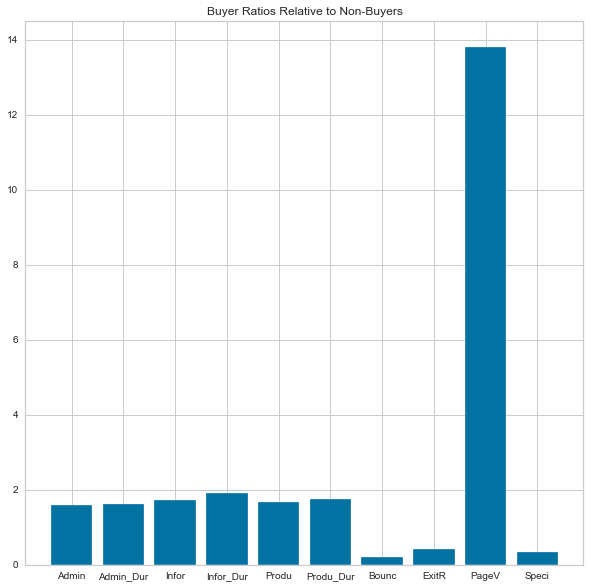

In [13]:
# Let's compare selective columns in terms of Buyers vs Browsers

print("\nKey Buyer Statistics\n")
print(buyer_stats.loc["mean"][:10])

print("\nKey Browser Statistics\n")
print(browser_stats.loc["mean"][:10])

relative_mean = (buyer_stats.loc["mean"][:10] / browser_stats.loc["mean"][:10]).values
#print(relative_mean)

# Plot

plot_cols    = [x[:5]+"_Dur" if idx in [1,3,5] else x[:5] for idx,x in enumerate(buyer_stats.columns) ][:10]
plt.rcParams['figure.figsize'] = [10, 10]
plt.title("Buyer Ratios Relative to Non-Buyers")
plt.bar(plot_cols,relative_mean)


Index(['VisitorType_New_Visitor', 'VisitorType_Other',
       'VisitorType_Returning_Visitor', 'Weekend_False', 'Weekend_True'],
      dtype='object')

Buyer stats

VisitorType_New_Visitor          0.221174
VisitorType_Other                0.008386
VisitorType_Returning_Visitor    0.770440
Weekend_False                    0.738470
Weekend_True                     0.261530
Name: mean, dtype: float64

Browser stats

VisitorType_New_Visitor          0.122050
VisitorType_Other                0.006621
VisitorType_Returning_Visitor    0.871330
Weekend_False                    0.772692
Weekend_True                     0.227308
Name: mean, dtype: float64


<BarContainer object of 5 artists>

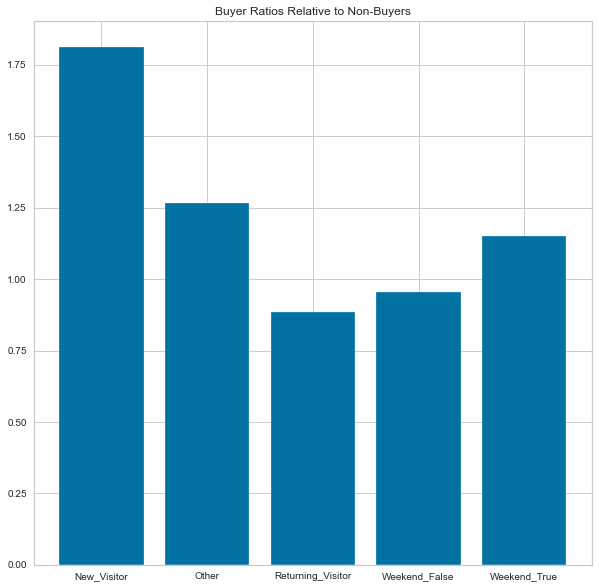

In [14]:
# Let's compare more columns in terms of Buyers vs Browsers

print(shopping_df.columns[-7:-2])

print("\nBuyer stats\n")
print(buyer_stats.loc["mean"][-7:-2])

print("\nBrowser stats\n")
print(browser_stats.loc["mean"][-7:-2])

relative_mean = (buyer_stats.loc["mean"][-7:-2] / browser_stats.loc["mean"][-7:-2]).values
#print(relative_mean)

plot_cols    = [x[x.find("_")+1:] for x in buyer_stats.columns ][-7:-2]
plot_cols[-2]= "Weekend_"+plot_cols[-2]
plot_cols[-1]= "Weekend_"+plot_cols[-1]
#print(plot_cols)

plt.rcParams['figure.figsize'] = [10, 10]
plt.title("Buyer Ratios Relative to Non-Buyers")
plt.bar(plot_cols,relative_mean)

### Interpretation of the Visualizations


These values represent the ratio of buyers/non-buyers for each metric (hence pseudo normalized)

Values close to 1 mean that the patterns of buyers / non-buyers are very similar despite the feature

Values > 1 are significantly different and could be meaningful features.  PageValues appears to be one of interest.

Values significantly < 1 could also be significant e.g .Bounce_Rates

### Feature Importance Ranking

We are also going to quickly run a classifier that offers explainability of the predictive values of the features (e.g. 

RandomForest).  Although this is not our final model, this process will help to identify features that have higher predictive 

values than others.  PageValues once again shows up as an important feature using both approaches as do others.

The most informative features are shown and ranked below.









Feature Ranking:

01. PageValues 31.3
02. ExitRates 8.8
03. ProductRelated_Duration 8.0
04. ProductRelated 7.9
05. BounceRates 5.8
06. Administrative 5.8
07. Administrative_Duration 5.6
08. TrafficType 5.2
09. Region 4.8
10. Browser 3.5
11. OperatingSystems 3.2
12. Informational_Duration 3.2
13. Informational 3.1
14. SpecialDay 1.0
15. Weekend_True 0.8
16. Weekend_False 0.8
17. VisitorType_New_Visitor 0.7
18. VisitorType_Returning_Visitor 0.5
19. VisitorType_Other 0.1


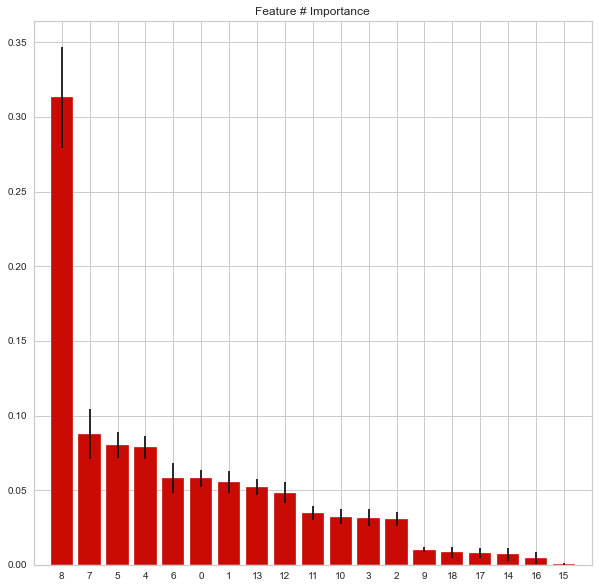

In [15]:
# Run the feature importance function to highlight potentially important features

(indices,importances) = feature_importance(X_train,y_train,train_df.iloc[:,:-2].columns,bPrint=True,bPlot=True)


## Run Classifiers


For this model

True Positive (TP)  - Predict purchase / purchase made = True Purchase

True Negative (TN)  - Predict no purchase / none made = True No Purchase

False Positive (FP) - Predict purchase / no purchase made = False Purchase

False Negative (FN) - Predict no purchase / purchase made = False No Purchase = Purchase


Accuracy - Correct predictions (TP+TN) divided by the total number of predictions.  This is skewed by class imbalances. 

Precision - True Positives divided by the number of True Positives and False Positives or Positive Predictive Value (PPV).
This is the classifier's exactness (differentiates positives) and low precision can also indicate a large number of False Positives.

Recall - True Positives divided by the True Positives plus False Negatives. This is positive predictions divided by the number of positive class values or the True Positive Rate. Low recall indicates many False Negatives.

F-score is the harmonic mean of Precision and Recall

--

### The Fallacy of Accuracy

It is tempting to just consider "Accuracy" as the key metric in this exercise but *classification accuracy is not enough* when classes are imbalanced (e.g 14% purchase ratio).

To illustrate the "Fallacy of Accuracy" (or Accuracy Paradox), I created a Lazy classifier.  It does not train and will always return a NO_PURCHASE value.  When compared on just "Accuracy" it looks OK vs other classifiers.  It is only when one looks at "Precision","Recall","F1" etc. that the problems become apparent as it scores a zero and its super laziness and lack of utility is revealed.

I also created a "Too Optimistic" Classifier that will alway predict a PURCHASE.  We can see how Recall gets skewed in that model.

"Lazy" has high accuracy because even though TP is zero / TN is a high number hence a high score.  Precision is zero because it cannot differentiate a True Positive (can't predict a purchase)

Optimistic has low accuracy but perfect Recall because it always predicts a purchase correctly and never generates a false negative

So we have opted for F-Score as the relevent metric to optimize.  A balanced F-score (F1 score) is the harmonic mean of precision and recall.  We are thus judging the model 


In [16]:
ml_models = [("Lazy", LazyClassifier(majority_class=NO_PURCHASE)),
             ("Too Optimistic", LazyClassifier(majority_class=PURCHASE)),
             ("Logistic (Linear)",LogisticRegression()),
             ("Support Vector",SVC()),
             ("Random Forest",RandomForestClassifier(n_estimators=10)),
             ("XGBoost", XGBClassifier(n_estimators=100)),
]
scoreboard.score_models(ml_models, X_train, y_train, X_test, y_test)   
scoreboard.print()

Running Lazy
Running Too Optimistic
Running Logistic (Linear)
Running Support Vector
Running Random Forest
Running XGBoost
[04:48:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Model  Accuracy  Precision    Recall        F1  \
5            XGBoost  0.947394   0.737430  0.676923  0.705882   
4      Random Forest  0.942133   0.737179  0.589744  0.655271   
2  Logistic (Linear)  0.934003   0.776699  0.410256  0.536913   
1     Too Optimistic  0.093257   0.093257  1.000000  0.170604   
3     Support Vector  0.907700   1.000000  0.010256  0.020305   
0               Lazy  0.906743   0.000000  0.000000  0.000000   

                        CM         Train   Predict  
5  [[1849, 47], [63, 132]]  2.507876e+00  0.002560  
4  [[1855, 41], [80, 115]]  9.453150e-02  0.003768  
2  [[1873, 23], [115, 80]]  8.305380e-02  0.001158  
1    [[0, 1896], [0, 195]]  9.000000e-07  0.000012  
3    [[1896, 0], [193, 2]]  1.264474e+00  0.144728  
0    [[1896, 0], [195, 0]]  1.000000e-06  0.000037

Plotting AUC:  Logistic (Linear)
Plotting AUC:  Random Forest
Plotting AUC:  XGBoost
[04:49:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


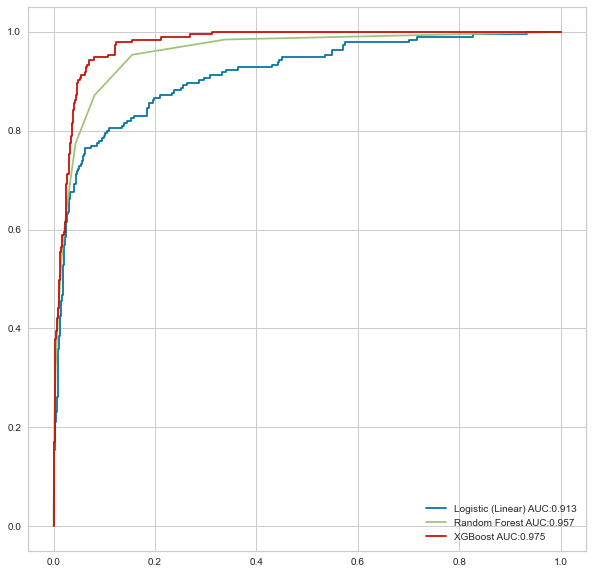

In [17]:
ml_models = [("Logistic (Linear)",LogisticRegression()),
             ("Random Forest",RandomForestClassifier(n_estimators=10)),
             ("XGBoost", XGBClassifier(n_estimators=100)),
]

scoreboard.plot_AUC_models(ml_models, X_train, y_train, X_test, y_test)   

## Comment on Classifiers and AUC Score


AUC score for the baseline XGBoost case is 0.975.

AUC score 1 represents perfect classifier, and 0.5 represents a worthless classifier.



## Hyperparameter Tuning of the XGBoost Model


XGBoost has proven to be a solid performer for a wide range of challenging problems (e.g. Kaggle) so it is no surprise that it has scored well relative to other models on a standalone and AutoML context.

We would like to do 2 things before formulating the Best Model: 

1) Use a weighted XGBoost model to deal with the Class Imbalance problem and 

2) Tune other hyperparameters accordingly

We can solve for imbalanced classification problems by tuning the "scale_pos_weight" hyperparameter, which is set to 1.0 by default.

This parameter has the effect of weighing the balance of positive examples relative to negative examples when boosting decision trees. For our imbalanced binary classification data, the negative class refers to the majority class (NO_PURCHASE = Class 0) and the positive class refers to the minority class (PURCHASE = Class 1).

The scale_pos_weight value is used to scale the gradient for the positive class. This can help the model achieve better performance when making predictions on the positive class. However, incorrect settings of this hyperparameter may lead to overfitting the positive class and poorer performance on the negative class.

A suggested value is to set "scale_pos_weight" to the inverse of the class distribution. So our non-purchase percentage of ~85% suggests a (100/(100-85)) = 6.5 ratio that can be tuned.

So for the hyperparameter tuning we are going to use the baseline results from the AutoML and then add some reasonable hyperparameters including scale_pos_weight to adjust for CLASS IMBALANCES.


In [18]:
print("Hyperparameter tuning the XGBoost Model")

param_test = {
    'learning_rate':[0.1,0.05,0.01],
    'n_estimators':[100,150,200],
    'max_depth':[3,5,7,9],
    'min_child_weight':[5,10,16,20],
    'subsample':[0.1,0.25,0.35,0.5,1],
    'scale_pos_weight':[1,5,6.5,8]   
}

gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.05,
                                                 n_estimators=100,
                                                 max_depth=3,
                                                 min_child_weight=8,
                                                 subsample=0.1,
                                                 scale_pos_weight=6.5,
                                                 objective= 'binary:logistic'),
                       param_grid = param_test,
                       scoring='roc_auc',               
                       n_jobs=4,
                       verbose=2)

gsearch.fit(X_train, y_train)

print('Best Grid Search Parameters :',gsearch.best_params_)
print('Best Grid Search Score : ',    gsearch.best_score_)


Hyperparameter tuning the XGBoost Model
Fitting 5 folds for each of 2880 candidates, totalling 14400 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   12.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   30.6s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:   55.1s
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 3273 tasks      | elapsed:  6.4min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:  8.5min
[Parallel(n_jobs=4)]: Done 4893 tasks      | elapsed: 10.7min
[Parallel(n_jobs=4)]: Done 5824 tasks      | elapsed: 11.9min
[Parallel(n_jobs=4)]: Done 6837 tasks      | elapsed: 13.8min
[Parallel(n_jobs=4)]: Done 7930 tasks      | elapsed: 16.3min
[Parallel(n_jobs=4)]: Done 9105 tasks      | elapsed: 19.5min

[05:21:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Grid Search Parameters : {'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 20, 'n_estimators': 200, 'scale_pos_weight': 6.5, 'subsample': 0.5}
Best Grid Search Score :  0.8938214198412272


In [19]:
ml_models = [("XGB (HyperP)", XGBClassifier(**gsearch.best_params_))]
scoreboard.score_models(ml_models, X_train, y_train, X_test, y_test)
scoreboard.print()

Running XGB (HyperP)
[05:23:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Model  Accuracy  Precision    Recall        F1  \
6       XGB (HyperP)  0.939742   0.607477  1.000000  0.755814   
5            XGBoost  0.947394   0.737430  0.676923  0.705882   
4      Random Forest  0.942133   0.737179  0.589744  0.655271   
2  Logistic (Linear)  0.934003   0.776699  0.410256  0.536913   
1     Too Optimistic  0.093257   0.093257  1.000000  0.170604   
3     Support Vector  0.907700   1.000000  0.010256  0.020305   
0               Lazy  0.906743   0.000000  0.000000  0.000000   

                        CM         Train   Predict  
6  [[1770, 126], [0, 195]]  9.121882e-01  0.003666  
5  [[1849, 47], [63, 132]]  2.507876e+00  0.002560  
4  [[1855, 41], [80, 115]]  9.453150e-02  0.003768  
2  [[1873, 23], [115, 80]]  8.305380e-02  0.001158  
1    [[0, 1896], [0, 195]]  9.000000e-07  0.000012  
3    [[1896, 0], [193, 2]]  1.264474e+00  0.144728  
0    [[1896, 0], [195, 0]]  1.000000e-06  0.000037

In [20]:
# Save the best model as Best Model and display the most important features

best_model = XGBClassifier(**gsearch.best_params_)

best_model.fit(X_train,y_train)

print("Running Feature Importance: ","\n")

importances_df = pd.DataFrame({
    'Feature':    X_train.columns,
    'Importance': best_model.feature_importances_
})

importances_df = importances_df.sort_values(by='Importance', ascending=False)
importances_df = importances_df.set_index('Feature')

print(importances_df)

    

[05:24:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Running Feature Importance:  

                               Importance
Feature                                  
PageValues                       0.514163
SpecialDay                       0.080420
VisitorType_New_Visitor          0.049958
ProductRelated                   0.032484
Informational                    0.029990
VisitorType_Returning_Visitor    0.029917
ProductRelated_Duration          0.028964
TrafficType                      0.027956
Administrative                   0.026119
ExitRates                        0.024973
Browser                          0.023951
BounceRates                      0.023574
Administrative_Duration          0.022873
OperatingSystems             

##  Cluster Analysis

We are now going to reduce the data to the most relevant features and then run
a clustering analysis to determine logical clusters of shoppers.  This will 
aid us in a profiling exercise to determine similarities between shoppers and patterns
e.g. tends to browse and buy nothing / quickly exits / spends time in high value areas and purchases etc



In [21]:
# Extract the indices corresponding to a feature importance > 0.025 (IMPORTANCE_THRESHOLD)

most_important_df = importances_df[(importances_df["Importance"] > IMPORTANCE_THRESHOLD)]
print(most_important_df)
selected_columns = most_important_df.index.values
#print(selected_columns)


                               Importance
Feature                                  
PageValues                       0.514163
SpecialDay                       0.080420
VisitorType_New_Visitor          0.049958
ProductRelated                   0.032484
Informational                    0.029990
VisitorType_Returning_Visitor    0.029917
ProductRelated_Duration          0.028964
TrafficType                      0.027956
Administrative                   0.026119


In [22]:
# Perform cluster analysis on all of the one_hot encoded data (shopping_df)

X_cluster = shopping_df.iloc[:,:-2]
print(X_cluster.shape)

y_cluster = shopping_df["Revenue_True"].values.reshape(-1,1)
print(y_cluster.shape)



(12330, 29)
(12330, 1)


In [23]:
# Use PCA to determine the optimal count for the clusters

pca = PCA(n_components=8)
X_red = pca.fit_transform(X_cluster)
print(X_red.shape)

(12330, 8)


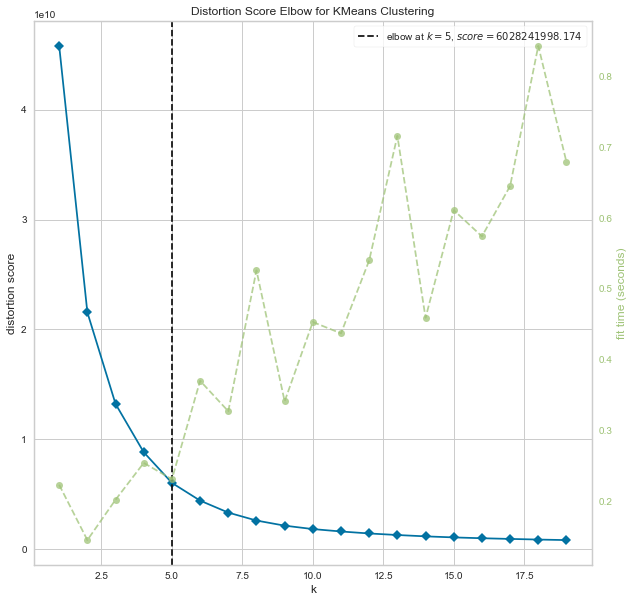

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [24]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))
visualizer.fit(X_red)
visualizer.show() 

In [25]:
#tsne_op = sklearn.manifold.TSNE(n_components=3, perplexity=2)
tsne_op = TSNE(n_components=3, perplexity=2)
X_red_t = np.array(tsne_op.fit_transform(X_cluster))

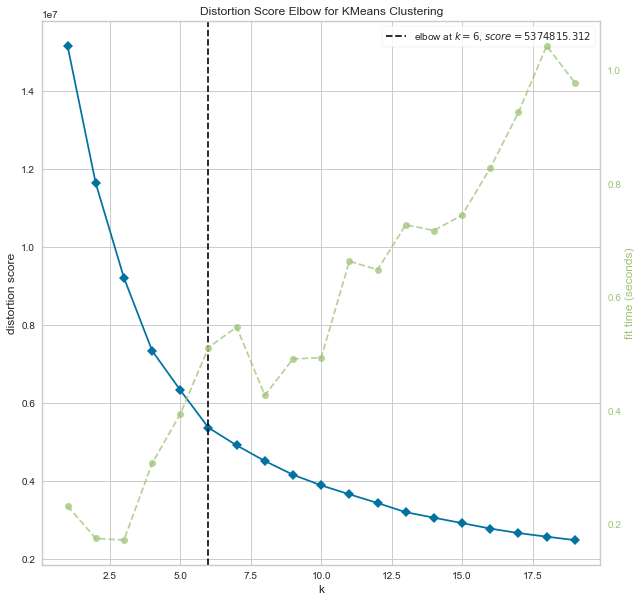

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))
visualizer.fit(X_red_t)
visualizer.show() 

### Conclusion on cluster sizing

Our analysis suggests 5 logical clusters - e.g. optimal point at the Elbow


In [27]:
n = 5                                           # Optimal number of clusters based on average of the Elbow methods
clusters = KMeans(n_clusters = n)
C_vals   = np.array(clusters.fit_predict(X_red))
print(np.unique(C_vals))

[0 1 2 3 4]


In [28]:
# Select columns from the feature reduction exercise e.g. selected columns and ...
# Add the Purchase information ("Purchase_True") and ...
# Add ClusterID to this data and save as a new file

X_save = pd.DataFrame(shopping_df[selected_columns])
X_save['Purchase'] = shopping_df.iloc[:,-1]
X_save['ClusterID'] = C_vals
X_save.head()
X_save.to_csv('shopping_clusters.csv', index=False)

In [29]:
# Reload the file and examine the training data

X_train = pd.read_csv('shopping_clusters.csv')
X=X_train.iloc[:,0:-2].values
X_train.head()

PageValues  SpecialDay  VisitorType_New_Visitor  ProductRelated  \
0         0.0         0.0                        0               1   
1         0.0         0.0                        0               2   
2         0.0         0.0                        0               1   
3         0.0         0.0                        0               2   
4         0.0         0.0                        0              10   

   Informational  VisitorType_Returning_Visitor  ProductRelated_Duration  \
0              0                              1                 0.000000   
1              0                              1                64.000000   
2              0                              1                 0.000000   
3              0                              1                 2.666667   
4              0                              1               627.500000   

   TrafficType  Administrative  Purchase  ClusterID  
0            1               0         0          0  
1            2               0         0          0  
2            3               0         0          0  
3            4               0         0          0  
4            4               0         0          0

In [30]:
column_values   = X_train['ClusterID'].values
unique_values_a = np.unique(column_values)
unique_values   = np.sort(unique_values_a)
print("Number of unique clusters =",len(unique_values),"and their Class IDs:",unique_values)

Number of unique clusters = 5 and their Class IDs: [0 1 2 3 4]


In [31]:
purchase_percentage       = np.zeros(len(unique_values))
representation_percentage = np.zeros(len(unique_values))

# Loop through the clusters

for index, item in enumerate(unique_values):
    locations = len(X_train[X_train['ClusterID']==item])
    purchases = len(X_train[(X_train['ClusterID']==item) & (X_train['Purchase']==1)])
    representation_percentage[index] = locations / len(X_train)
    purchase_percentage[index]       = purchases / locations 

Representation Percentage= [0.67518248 0.06934307 0.23941606 0.00081103 0.01524736]
Purchase Percentage= [0.11531532 0.28538012 0.21646341 0.2        0.33510638]


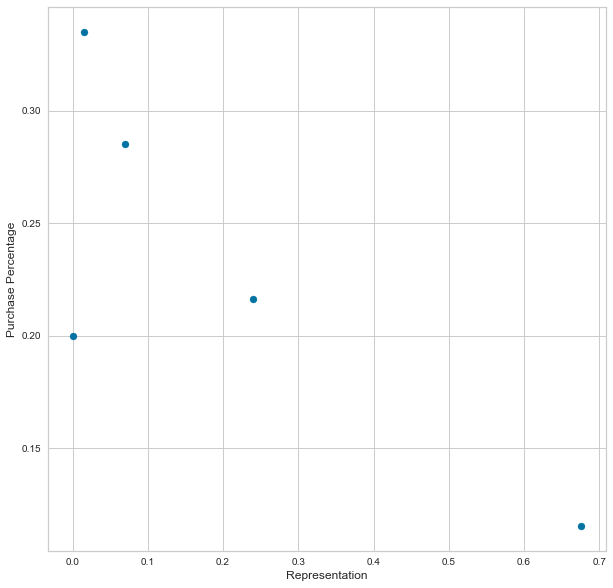

In [32]:
print('Representation Percentage=',representation_percentage)
print('Purchase Percentage=',purchase_percentage)
plt.scatter(representation_percentage,purchase_percentage)
plt.xlabel('Representation')
plt.ylabel('Purchase Percentage')
plt.show()

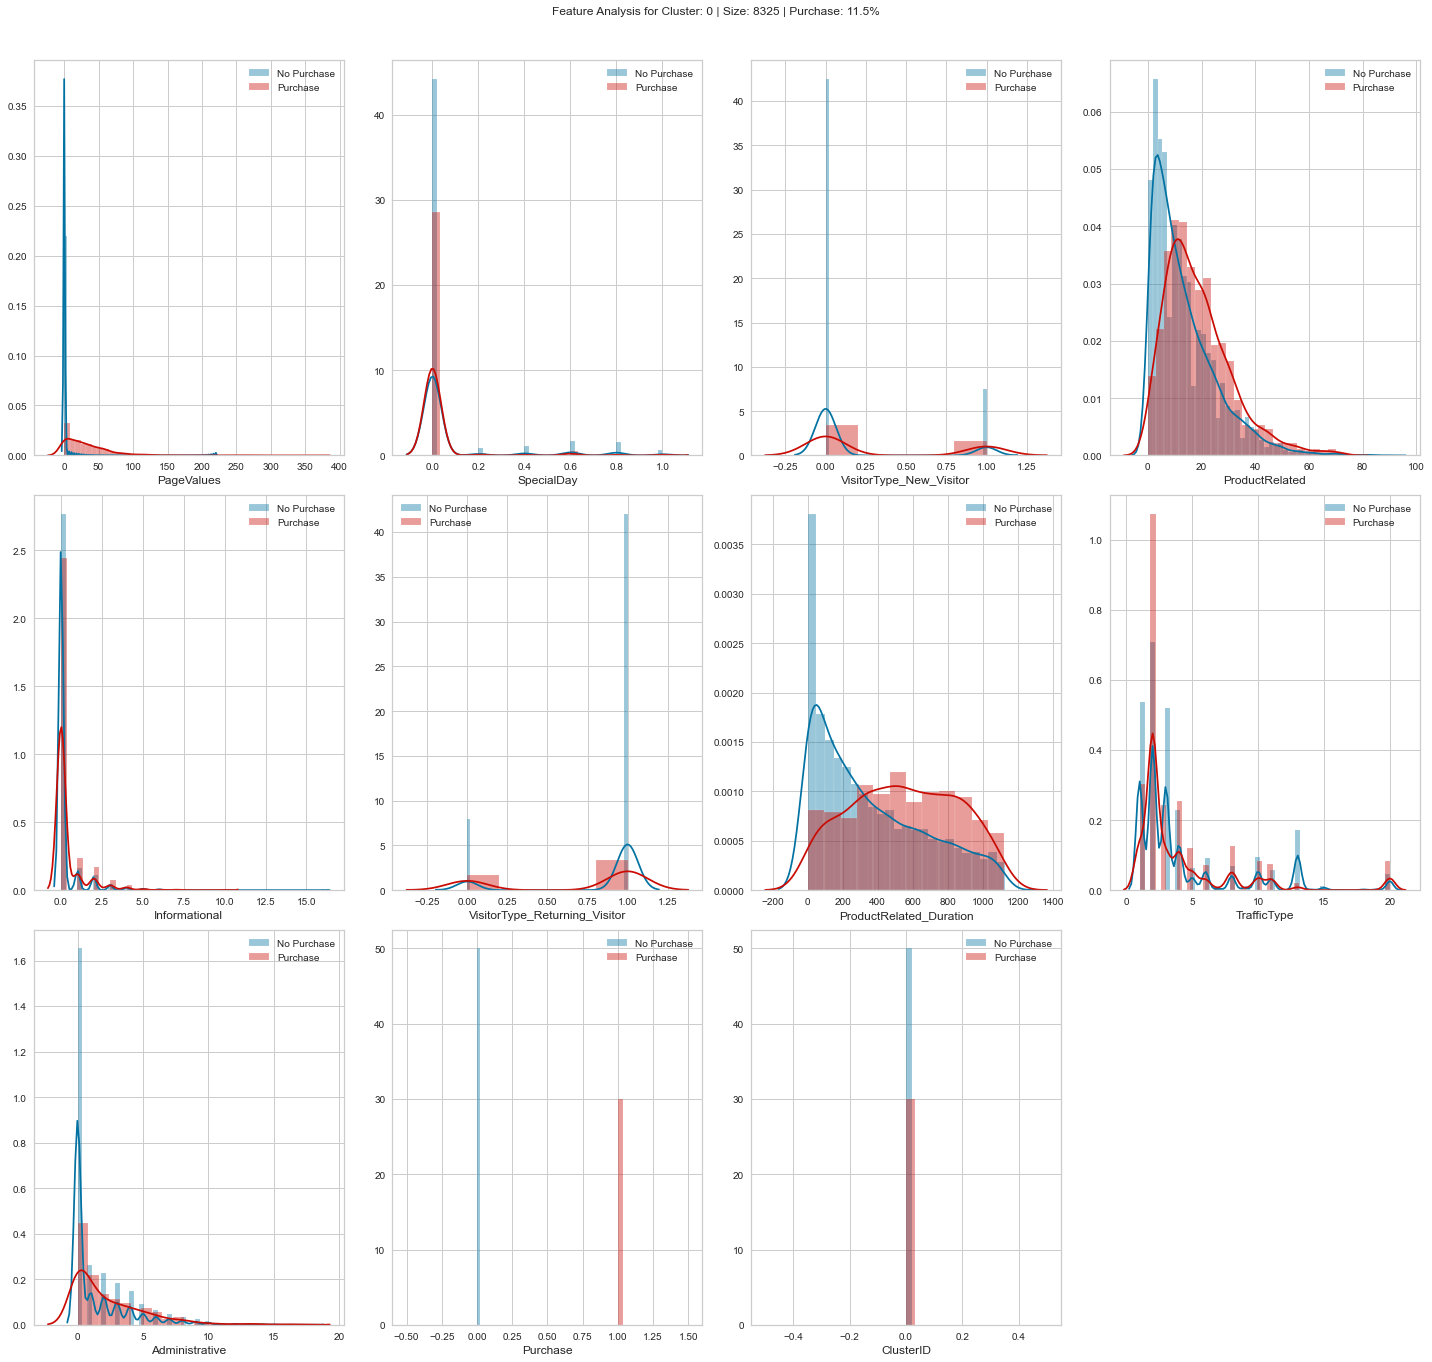

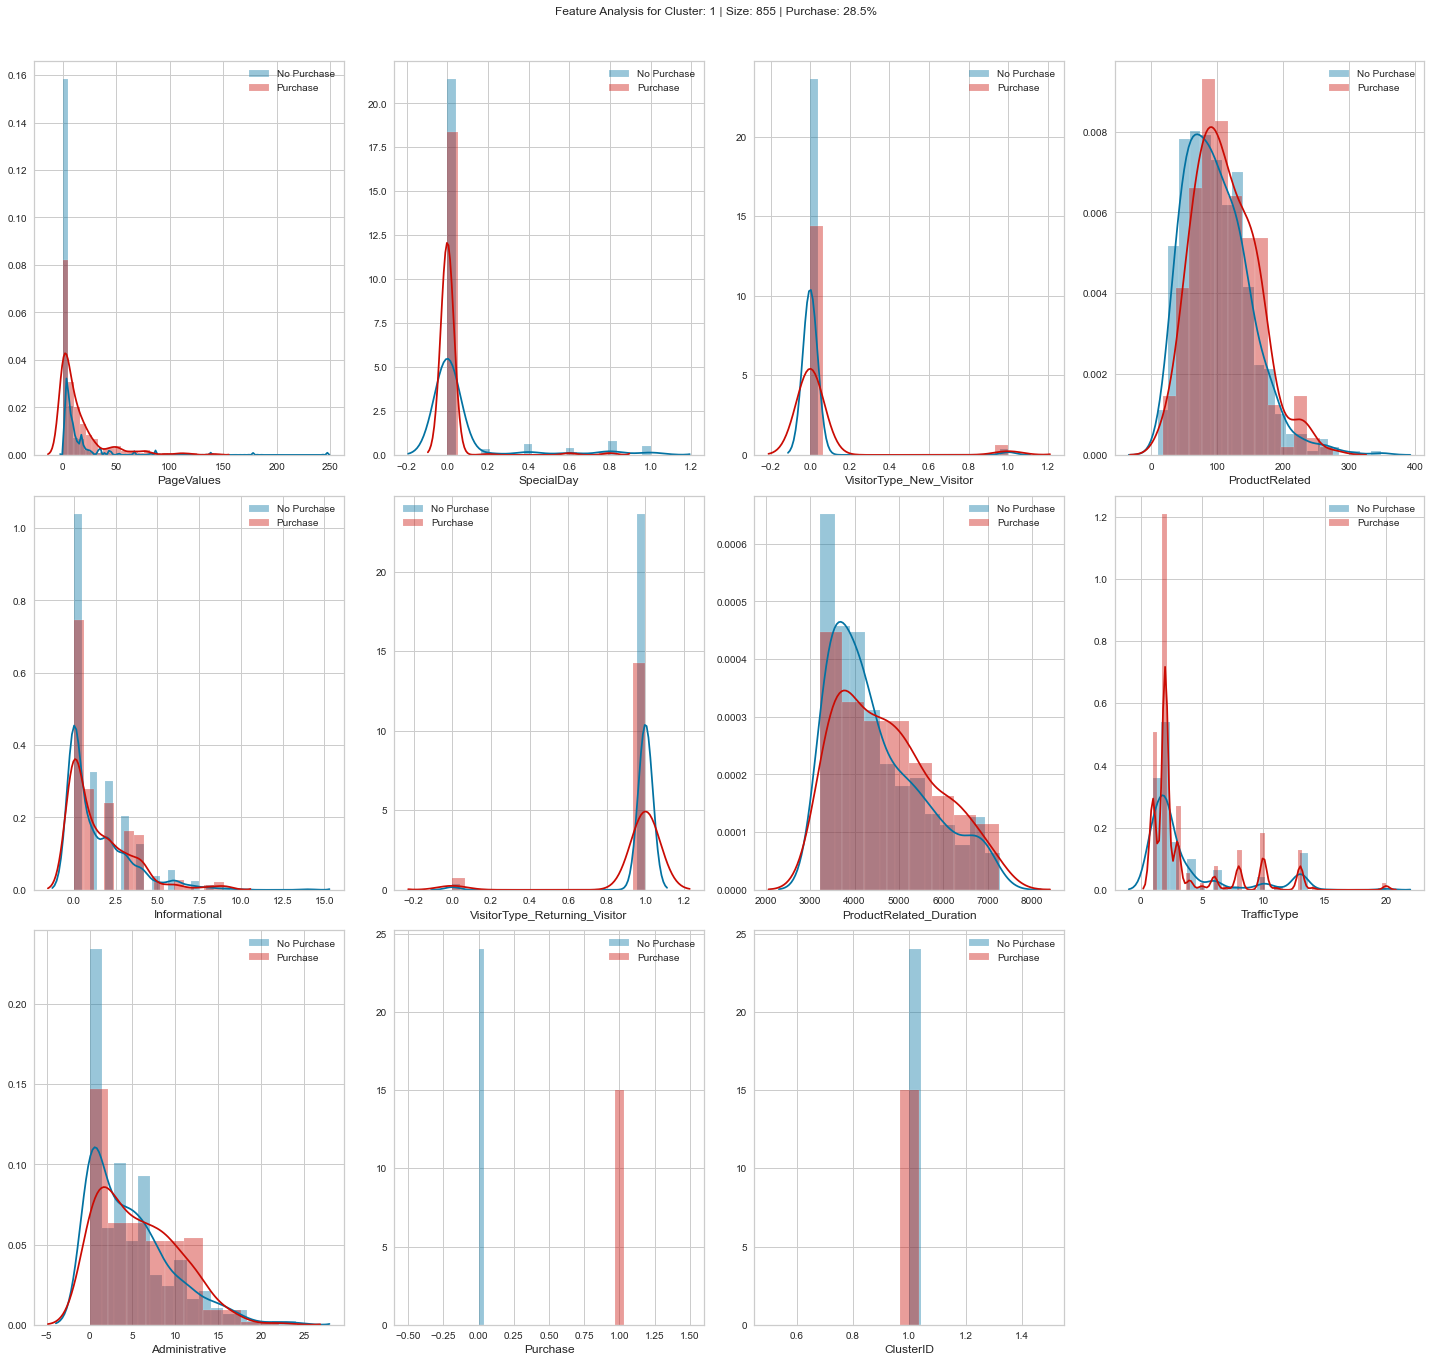

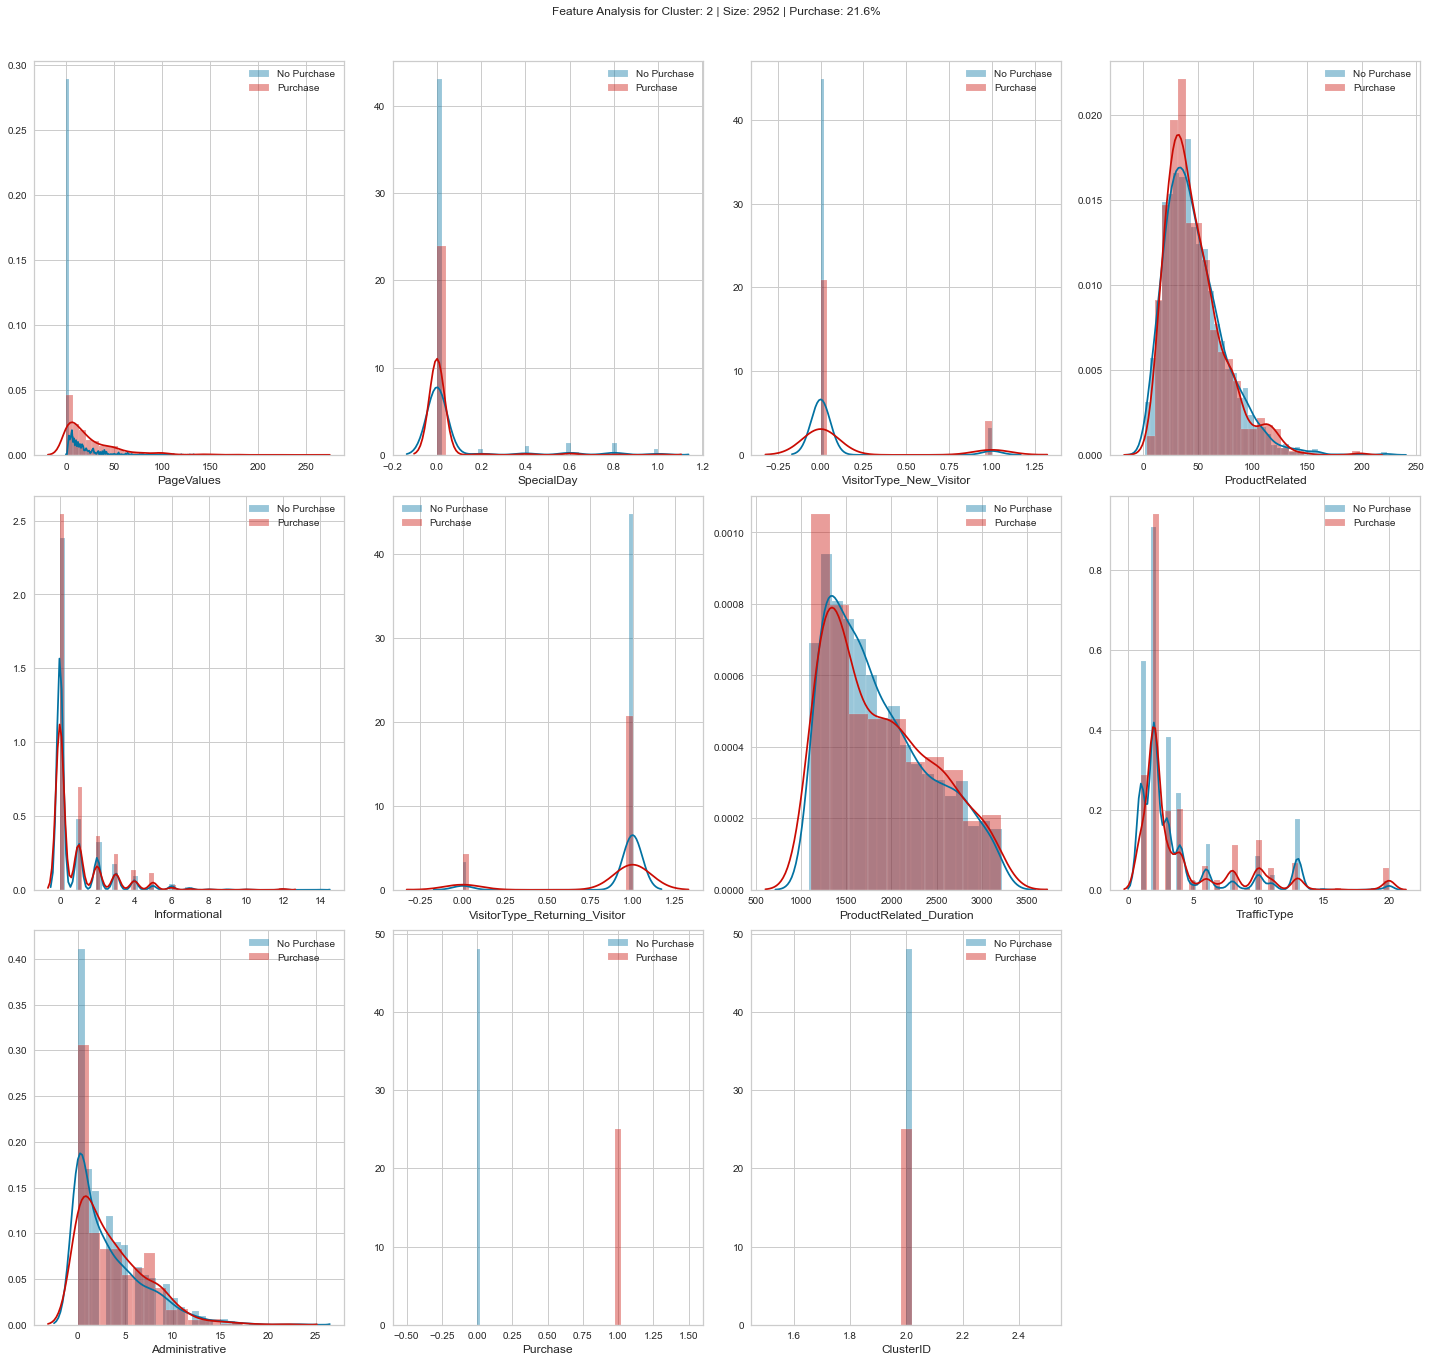

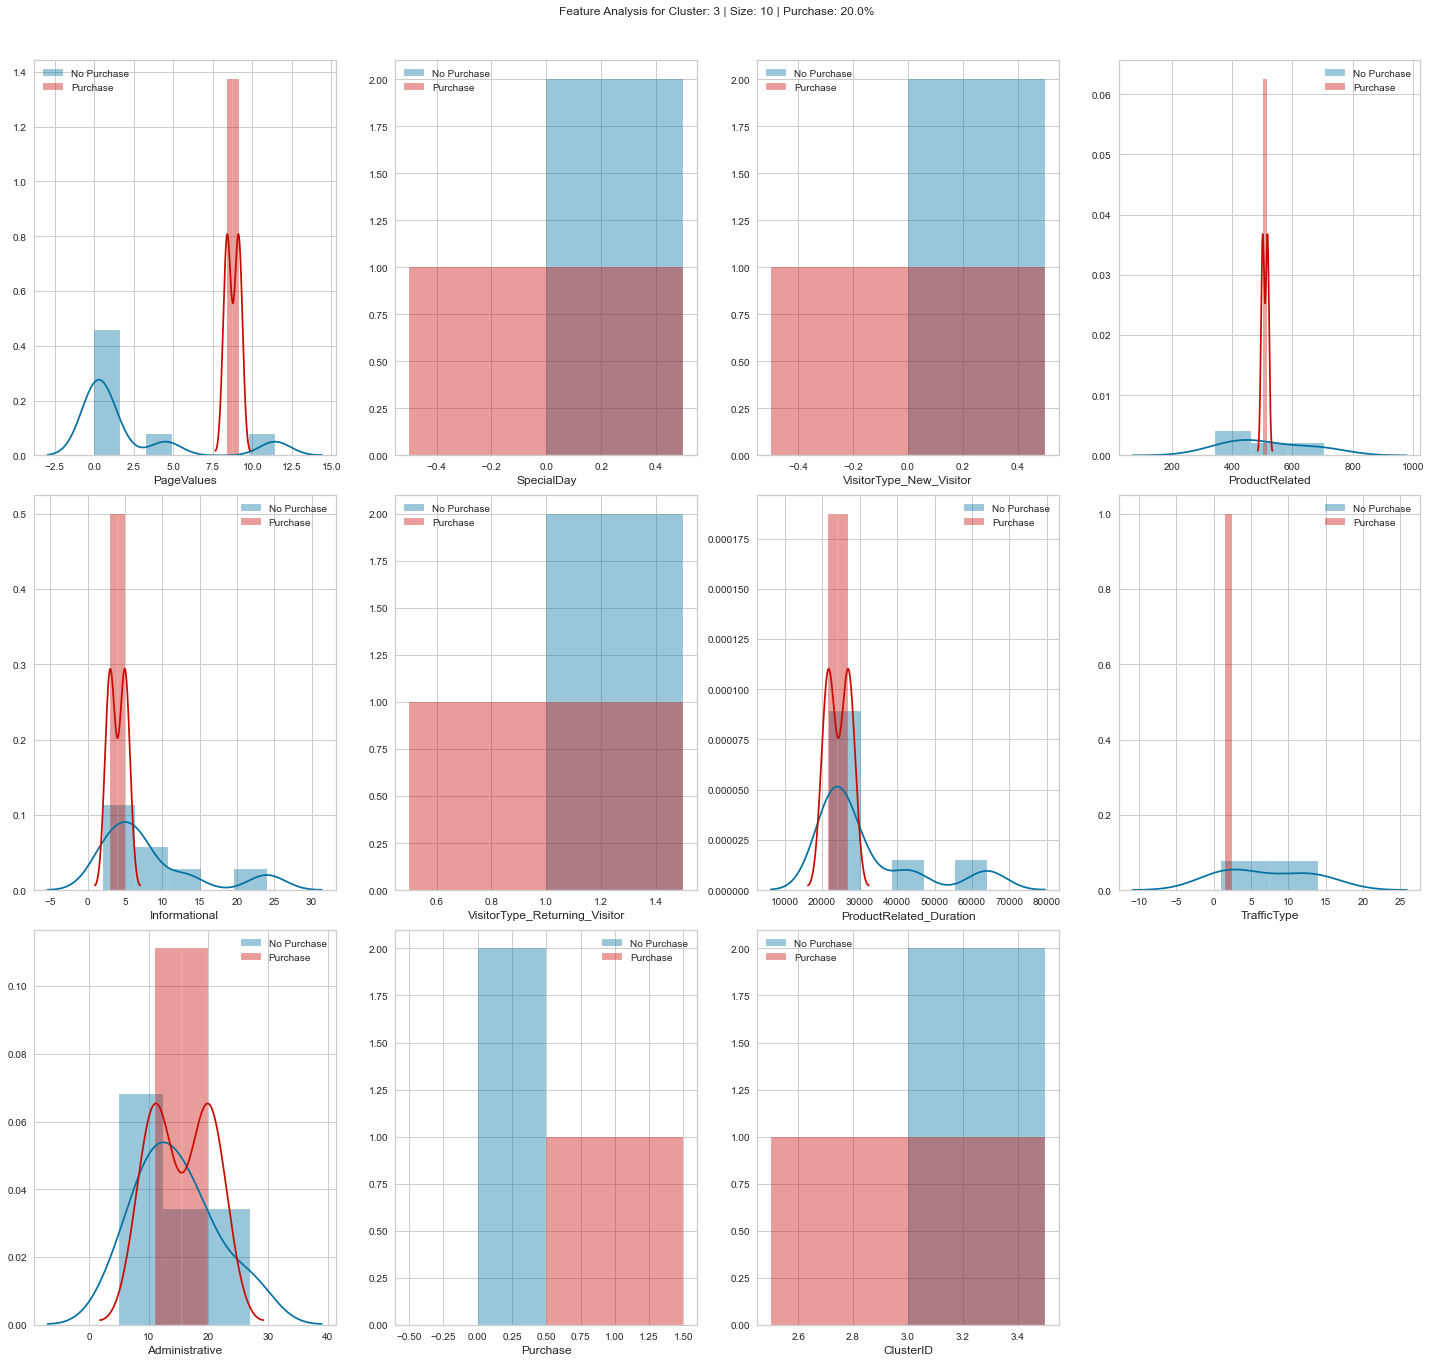

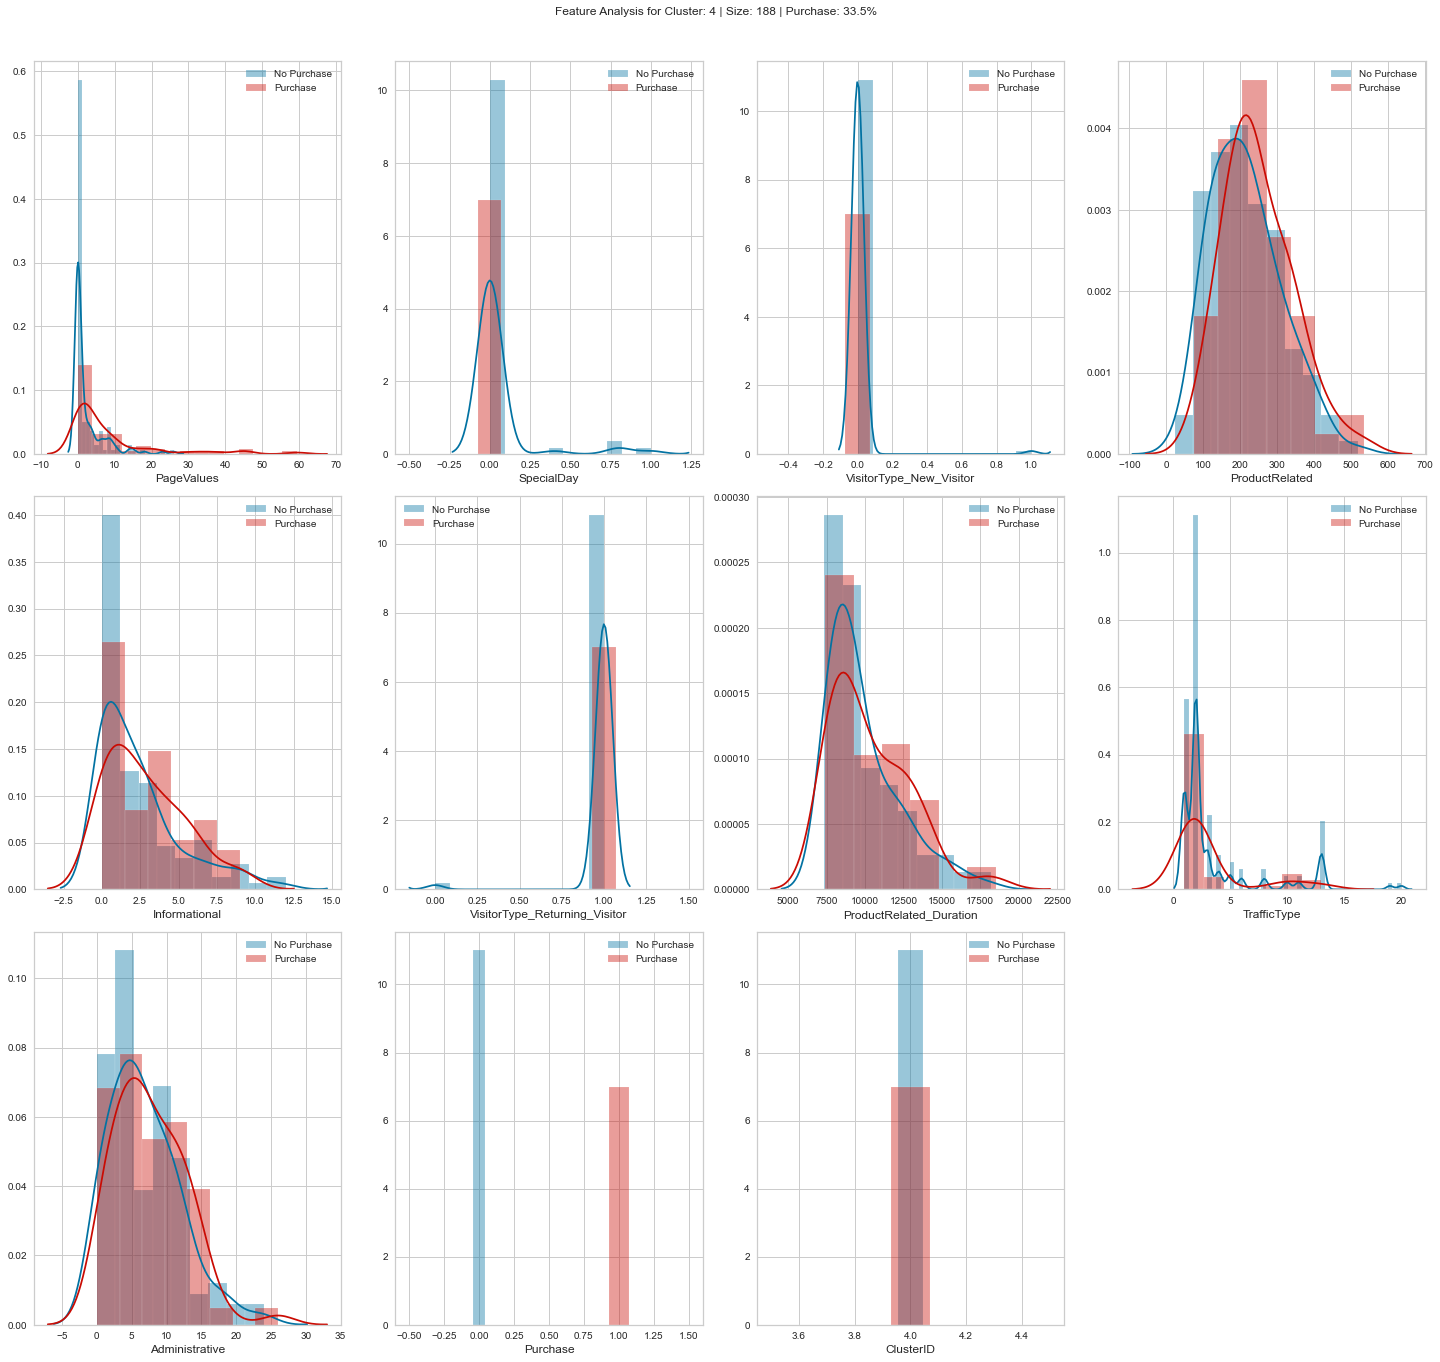

In [33]:
for cluster in unique_values:

    result      = X_train.loc[X_train['ClusterID'] == cluster]     # Data for this cluster
    n_cluster   = len(result)                                      # Size of cluster
    n_purchases = len(result[(result['Purchase']==1)])             # Purchases made by this cluster
    buy_pct     = (n_purchases / n_cluster) * 100                  # Purchase Percentage of Cluster 
    str_pct     = str(buy_pct)[:4] +"%"                            # String version of percentage for chart display

    fig = plt.figure(figsize = (20, 25))
    j = 0
    
    for i,item in enumerate(result.columns):
        plt.subplot(4, 4, j+1)
        j += 1
        sb.distplot(result[item][result['Purchase']==0], color='b', label = 'No Purchase')
        sb.distplot(result[item][result['Purchase']==1], color='r', label = 'Purchase')
        plt.legend(loc='best')
        
    fig.suptitle('Feature Analysis for Cluster: '+str(cluster) + ' | Size: '+ str(n_cluster) + ' | Purchase: '+ str_pct)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    
    plt.show()

### Cluster 0 - "Interested Shopper"

Count: 2980

Purchase(%): 21.5%

Description: 

Returning visitor who spends time on product related information and has an above average chance of making a purchase.  This  is the largest cohort of purchasers.


### Cluster 1 - "Passionate Researcher"

Count: 191

Purchase(%): 33.5%

Description: 

Returning visitor who spends a *long time* on the site, is interested in the product and spends an above average amount of time looking at product related information is *highly likely* to make a purchase




### Cluster 2 - "ERROR"

Count: 10

Purchase(%): 20%

Description: 

Customer count is too small and time spent on Product-related information is ridiculous.  Maybe erroneous shopping carts / checkouts etc.




### Cluster 3 - "Mostly Browsers"

Count: 8271

Purchase(%): 11.5% (Below Average)

Description: 

*Majority* of shoppers.  They are more likely  to be a *new visitor*, they spend a *below average* amount of time on Product information and more likely to *NOT* make a purchase



### Cluster 4 - "Back for More / Enthusiast"

Count: 878

Purchases: 28.5%

Description: 

Returning visitor who spends a long time on the site (but half the time on average as "Researchers") looking at product related information and is highly likely to make a purchase (though less likely than "Researcher").  More common than the rare "Researcher" but less common than "Shopper".


